# Preprocessing the DEM of France (RGE ALTI® 5m) for implementation into Earth Engine

Authors: [Guillaume Attard](guillaumeattard.com) & [Julien Bardonnet](https://github.com/jbardo)

#### Introduction
A Digital Elevation Model (DEM) is a description of the ground elevation. DEMs are used in many fields such as hydrology, agriculture, and natural risks analysis. Since few years, some high resolution DEMs have become open and freely available. Some of them are available on the [Earth Engine data catalog](https://developers.google.com/earth-engine/datasets/tags/dem), but only few are available at a very high resolution. And when it comes to analyze the human and financial consequences of natural disasters such as floods and sea level rise, this high resolution is needed.
 
Hence, the aim of this article is to detail the implementation steps of the high resolution France DEM (RGE ALTI® 5m - IGN) into Earth Engine.
 
This structure of the article reads as follow:
- the dataset is described,
- a procedure to automate the download of the DEM of multiple departments of France is developed,
- the DEM asc files are turned into geoTIFF files and merged into one,
- then, geoTIFF files are uploaded as new assets in Earth Engine.
 
#### Run me first
The following librairies are required:

In [1]:
import os
import shutil

from ftplib import FTP

import py7zr

import pandas as pd
import numpy as np
from rasterio.merge import merge
from osgeo import gdal, osr

import pprint

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

#### Description of the RGE ALTI® 5m dataset
The RGE ALTI® 5m dataset describes the ground elevation of France with a spatial resolution of 5x5m. It is produced by the National Institute of Geographic and Forest Information (IGN - https://www.ign.fr/) which is a public administrative establishment placed under the joint authority of the Ministries in charge of ecology and forestry. The full dataset description is available [here](https://geoservices.ign.fr/documentation/donnees/alti/rgealti).
 
The accuracy of the DEM varies according to areas and issues: it is increased to 20 cm in floodplain areas or coastal areas. The RGE ALTI® is updated from surveys obtained by airborne LIDAR or by correlation of aerial images. The dataset can be downloaded at a [1x1m resolution](https://geoservices.ign.fr/rgealti#telechargement1m) or at a [5x5m resolution](https://geoservices.ign.fr/rgealti#telechargement5m).

This dataset is published under the open licence [Etalab](https://www.etalab.gouv.fr/wp-content/uploads/2018/11/open-licence.pdf).

#### Dataset accessibility - automate download and extraction
The RGE ALTI® 5m dataset is splited in multiple `7-Zip` files, and all individual files are available [here](https://geoservices.ign.fr/rgealti#telechargement5m). These files are stored on a FTP server `ftp3.ign.fr` with a public username/password.

Then, a procedure is given below to get the info and download files stored on the FTP associated with the dataset:

In [2]:
# Define requested info to access the FTP.
URL = "ftp3.ign.fr"
USERNAME = "RGE_ALTI_ext"
PASSWORD = "Thae5eerohsei8ve"

# Define the name (glonbal variable) of the temp directory to store zip files.
TEMP_ZIP = "temp7z"

def ftp_get_filenames():
    """
    This function returns a list of filnames stored on 
    ftp3.ign.fr
    """
    with FTP(URL) as ftp:
        ftp.login(USERNAME, PASSWORD)
        filenames = ftp.nlst()
    return filenames


def download_rge5m_item(filename):
    """
    This function is used to download the zip DEM on ftp3.ign.fr
    """

    # Create the directory to store the downloaded file.
    os.makedirs(TEMP_ZIP, exist_ok = True)

    # Define the output filename.
    output_filepath = os.path.join(".", TEMP_ZIP, filename)

    # Download the file.
    with FTP(URL) as ftp:
        ftp.login(USERNAME, PASSWORD)
        with open(output_filepath, 'wb') as f:
            ftp.retrbinary('RETR ' + filename, f.write)
    print(filename, "is dowloaded.")

The `ftp_get_filenames()` function is used to store all files info into a pandas dataframe.

In [3]:
# Create a pandas.df to store the list of available files.
df = pd.DataFrame(data=ftp_get_filenames(), columns=["name"])

# Rearrange the content of the pandas df.
df = pd.concat([df, df["name"].str.split("_", expand=True)], axis=1)
df = df.rename(columns = {
    0:"dataset", 1:"version", 2:"res", 3:"filetype", 4:"crs", 
    5:"dep", 6:"date"})

# Loc the dataset of interest RGE Alti 5m.
df = df.loc[(df.dataset == "RGEALTI") & (df.res == "5M")]

# Clean the date and set the name as index.
df['date'] = df['date'].apply(lambda x:x[:-3])
df = df.set_index("name")

df.head()

,dataset,version,res,filetype,crs,dep,date
name,,,,,,,
RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D001_2020-11-13.7z,RGEALTI,2-0,5M,ASC,LAMB93-IGN69,D001,2020-11-13
RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D002_2020-09-04.7z,RGEALTI,2-0,5M,ASC,LAMB93-IGN69,D002,2020-09-04
RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D003_2021-08-25.7z,RGEALTI,2-0,5M,ASC,LAMB93-IGN69,D003,2021-08-25
RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D004_2021-08-04.7z,RGEALTI,2-0,5M,ASC,LAMB93-IGN69,D004,2021-08-04
RGEALTI_2-0_5M_ASC_LAMB93-IGN69_D005_2020-10-14.7z,RGEALTI,2-0,5M,ASC,LAMB93-IGN69,D005,2020-10-14


In the following we define a department of interest corresponding to the southern part of Corsica (France), and we print the associated file:

In [4]:
deps_of_interest = ['D02A']

# Loc lines of interest in the pandas.df.
dfi = df.loc[df.dep.isin(deps_of_interest)]
dfi

,dataset,version,res,filetype,crs,dep,date
name,,,,,,,
RGEALTI_2-0_5M_ASC_LAMB93-IGN78C_D02A_2020-04-16.7z,RGEALTI,2-0,5M,ASC,LAMB93-IGN78C,D02A,2020-04-16


The file of interest is downloaded using our previously define function `download_rge5m_item()`. Please note that the server can be very slow.

In [5]:
filename = dfi.index[0]

# Uncomment below to download.
#download_rge5m_item(filename)

Then we need to extract the content of the downloaded file. A procedure is defined accordingly:

In [6]:
# Define the name (glonbal variable) of the temp directory to store extracted files.
EXTRACTION_PATH = "RGE_ALTI_5m"

def extract_rge5m(filename):
    """
    This function is used to extract the zip DEM.
    """
    input_filepath = os.path.join(".", TEMP_ZIP, filename)
    os.makedirs(EXTRACTION_PATH, exist_ok = True)

    with py7zr.SevenZipFile(input_filepath, mode='r') as archive:
        archive.extractall(path=EXTRACTION_PATH)
    print(filename, "is extracted.")

The function is applied to our filename of interest.

In [7]:
extract_rge5m(filename)

RGEALTI_2-0_5M_ASC_LAMB93-IGN78C_D02A_2020-04-16.7z is extracted.


Now the unzip folder should look like this:

```
RGE_ALTI_5m
└───RGEALTI_2-0_5M_ASC_LAMB93-IGN78C_D02A_2020-04-16
    └───RGEALTI
        │   LISEZ-MOI.txt
        └───1_DONNEES_LIVRAISON_2021-06-00061
        │   │   RGEALTI_MNT_5M_ASC_LAMB93_IGN78C_D02A.md5
        │   └───RGEALTI_MNT_5M_ASC_LAMB93_IGN78C_D02A
        │       │   RGEALTI_FXX_1155_6135_MNT_LAMB93_IGN78C.asc
        │       │   RGEALTI_FXX_1155_6140_MNT_LAMB93_IGN78C.asc
        │       │   RGEALTI_FXX_1155_6145_MNT_LAMB93_IGN78C.asc
        │       │   ...
        └───2_METADONNEES_LIVRAISON_2021-06-00061
        └───3_SUPPLEMENTS_LIVRAISON_2021-06-00061
```
        

The folder/subfolder names depend on the acquisition period of the dataset, and on the department of interest. Hence, a procedure is given to go straight to the path where the asc files of the DEM are located. We store all asc files into a list.

In [8]:
def get_path_asc_paths(filename):
    """
    This funciton returns a list of paths of asc files.
    """
    for root, dirs, files in os.walk(EXTRACTION_PATH, filename[:-3]):
        if "1_DONNEES_LIVRAISON" in root:
            asc_paths_list = [os.path.join(root, name) for name in files if name.endswith(".asc")]

    return asc_paths_list

asc_paths_list = get_path_asc_paths(filename)
pprint.pprint(asc_paths_list[:3])

['RGE_ALTI_5m\\RGEALTI_2-0_5M_ASC_LAMB93-IGN78C_D02A_2020-04-16\\RGEALTI\\1_DONNEES_LIVRAISON_2021-06-00061\\RGEALTI_MNT_5M_ASC_LAMB93_IGN78C_D02A\\RGEALTI_FXX_1155_6135_MNT_LAMB93_IGN78C.asc',
 'RGE_ALTI_5m\\RGEALTI_2-0_5M_ASC_LAMB93-IGN78C_D02A_2020-04-16\\RGEALTI\\1_DONNEES_LIVRAISON_2021-06-00061\\RGEALTI_MNT_5M_ASC_LAMB93_IGN78C_D02A\\RGEALTI_FXX_1155_6140_MNT_LAMB93_IGN78C.asc',
 'RGE_ALTI_5m\\RGEALTI_2-0_5M_ASC_LAMB93-IGN78C_D02A_2020-04-16\\RGEALTI\\1_DONNEES_LIVRAISON_2021-06-00061\\RGEALTI_MNT_5M_ASC_LAMB93_IGN78C_D02A\\RGEALTI_FXX_1155_6145_MNT_LAMB93_IGN78C.asc']


Let's have a look at a DEM piece located in this folder:

In [21]:
# Select one asc file in the DEM directory.
sample_path = asc_paths_list[10]

# Open and print the 10 first lines.
with open(sample_path) as file:
    content = file.readlines()
    header = content[:6]
    data = content[6:]

pprint.pprint(header)

['ncols        1000\n',
 'nrows        1000\n',
 'xllcorner    1159997.500000000000\n',
 'yllcorner    6150002.500000000000\n',
 'cellsize     5.000000000000\n',
 'NODATA_value  -99999.00\n']


As we can see, the header of the file gives us:
- `ncols` the number of columns,
- `nrows` the number of rows,
- `xllcorner` the x location (in epsg 2154) of the lower left corner of the DEM,
- `yllcorner` the y location (in epsg 2154) of the lower left corner of the DEM,
- `cellsize` the cell size in meters,
- `NODATA_value` the nodata value.

On the other hand, the rest of the content represent the elevation data. A sample is printed as follow:

In [31]:
pprint.pprint(data[0][:1000])

(' 137.72 135.22 132.77 131.52 129.30 126.48 125.05 121.91 119.69 117.84 '
 '115.75 114.05 112.91 110.66 108.65 106.11 102.72 100.19 97.70 95.16 94.12 '
 '92.69 91.23 90.33 89.58 88.90 86.30 83.33 79.54 78.29 75.80 76.48 77.04 '
 '77.47 76.48 75.37 73.54 73.33 73.01 72.68 72.43 72.41 71.37 70.12 67.66 '
 '64.11 60.24 57.34 55.27 45.11 37.27 35.95 33.24 32.04 27.27 22.07 14.22 5.03 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 -99999.00 '
 '-99999.00 -99999.00 

We define a function to store these data into a dictionary. For further manipulations, it will be convenient to define a class associated with RGE pieces. Hence, we also define such a class in which the DEM data is loaded using the `np.loadtxt()` function.

In [92]:
def get_header_asc(filepath):
    """
    This function reads the header of an asc file and returns 
    the data into a dictionnary
    """
    file = open(filepath)
    content = file.readlines()[:6]
    content = [item.split() for item in content]
    return dict(content)

class RGEitem():
    """
    This class is used to handle RGE items.
    """
    def __init__(self, filepath):
        self.filename = os.path.basename(filepath)
        self.data = np.loadtxt(filepath, skiprows=6)
        self.header = get_header_asc(filepath)
        self.ncols = int(self.header['ncols'])
        self.nrows = int(self.header['nrows'])
        self.xllc = float(self.header['xllcorner'])
        self.yllc = float(self.header['yllcorner'])
        self.res = float(self.header['cellsize'])
        self.zmin = float(self.data.min())
        self.zmax = float(self.data.max())
        self.novalue = -99999.

Let's have a look at our sample item:

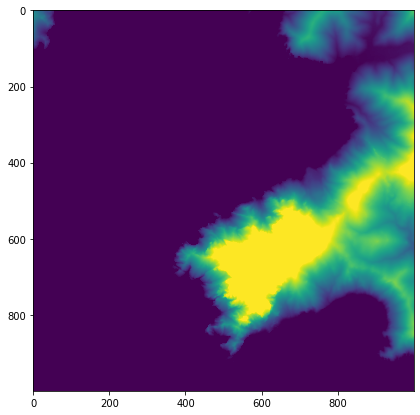

The max elevation is 619.01 m.


In [93]:
file = RGEitem(sample_path)

plt.rcParams["figure.figsize"] = (7,7)
plt.imshow(file.data, vmin=0, vmax=300)
plt.show()

print("The max elevation is", file.zmax,"m.")

#### Turn `.asc` files into `geoTIFF` files

Now that we see how to download and access these data, we can transform each `.asc` file into a `geoTIFF` using the osgeo library. We do this as follow:

In [82]:
def asc_to_tif(file, output_rastername, epsg):
    """
    This function transform an .asc file into a geoTIFF.
    file: an RGEitem
    output_rastername (str): name of the output geoTIFF
    epsg (int): projection system
    nodatavalue (int).
    """
    xmin = file.xllc
    ymax = file.yllc + file.nrows * file.res 

    geotransform = (xmin, file.res, 0, ymax, 0, -file.res)

    # Open the file
    output_raster = gdal.GetDriverByName('GTiff').Create(output_rastername, file.ncols, file.nrows, 1, gdal.GDT_Float32)
    # Specify the coordinates.  
    output_raster.SetGeoTransform(geotransform)
    # Establish the coordinate encoding.  
    srs = osr.SpatialReference()  
    # Specify the projection.               
    srs.ImportFromEPSG(epsg)                     
    # Export the coordinate system to the file.
    output_raster.SetProjection(srs.ExportToWkt())
    # Writes the array.   
    output_raster.GetRasterBand(1).WriteArray(file.data)
    # Set nodata value.  
    output_raster.GetRasterBand(1).SetNoDataValue(file.novalue) 
    output_raster.FlushCache()

We apply the function to get the `geoTIFF` associated with our sample and we open it using `rasterio`.

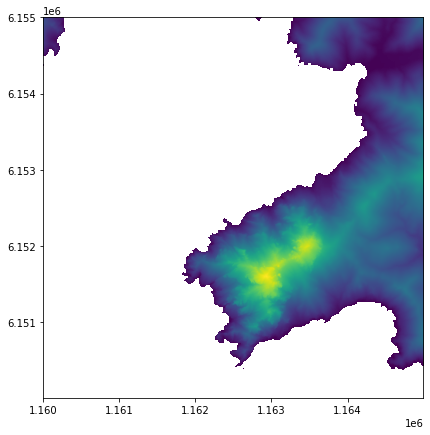

In [83]:
# Generate the tif.
rastername = "myraster.tif"
asc_to_tif(file, rastername, 2154)

import rasterio
from rasterio.plot import show
img = rasterio.open(rastername)
show(img)
plt.show()

Note that x and y axes are now in line with the coordinate reference system we are using (epsg:2154). 

#### Merge `geoTIFF` files into a mosaic

We can now define a procedure to trnasform each `.asc` file into `tif` and create a mosaic with all these files following the procedure described by [Abdishakur](https://medium.com/spatial-data-science/how-to-mosaic-merge-raster-data-in-python-fb18e44f3c8).

In [95]:
def create_rge_mosaic(asc_paths_list, mosaic_path, crs):
    """
    This function creates a mosaic associated to multiple tif stored in
    a folder `dempath`.
    dempath (str): path of the directory where .tif files are stored,
    moisaic_math (str): path where the mosaix should be saved
    crs (int): coordinate reference system (ex. 2154 for EPSG:2154)
    """
    raster_to_mosaic_list = []
    output_raster_paths_list = []

    for ascpath in asc_paths_list:
        # Define the file as a new RGE item.
        file = RGEitem(ascpath)
        filename = file.filename

        # Define the folder path to save intermediate tifs.
        dir_res = os.path.join('.', 'local_tifs')
        # Create target Directory
        os.makedirs(dir_res, exist_ok = True)

        # Define the name of the output tif item.
        output_raster_path = os.path.join(dir_res, filename.replace("asc", "tif"))
        output_raster_paths_list.append(output_raster_path)
        
        # Transform the asc into a geoTIFF.
        asc_to_tif(file, output_raster_path, crs)

        # The raster files will be closed later (after merging).
        local_raster = rasterio.open(output_raster_path)
        raster_to_mosaic_list.append(local_raster)

    # Merge all geoTIFF into one.
    mosaic, output = merge(raster_to_mosaic_list)
    output_meta = raster_to_mosaic_list[0].meta.copy()
    output_meta.update(
        {"driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": output,
        }
    )

    # Save the result.
    with rasterio.open(mosaic_path, "w", **output_meta) as m:
        m.write(mosaic)
    
    # We purge the local_tif folder. Before, files must be closed.
    for file in raster_to_mosaic_list:
        file.close()
        
    shutil.rmtree("./local_tifs")

The function is applied to create the mosaic of the southern part of Corsica (department 2A):

In [96]:
mosaic_path = "./result/mymosaic2A_2022.tif"
create_rge_mosaic(asc_paths_list, mosaic_path, 2154)

The result can be displayed as follows. On this figure the initial sample area is delineated with a red rectangle.

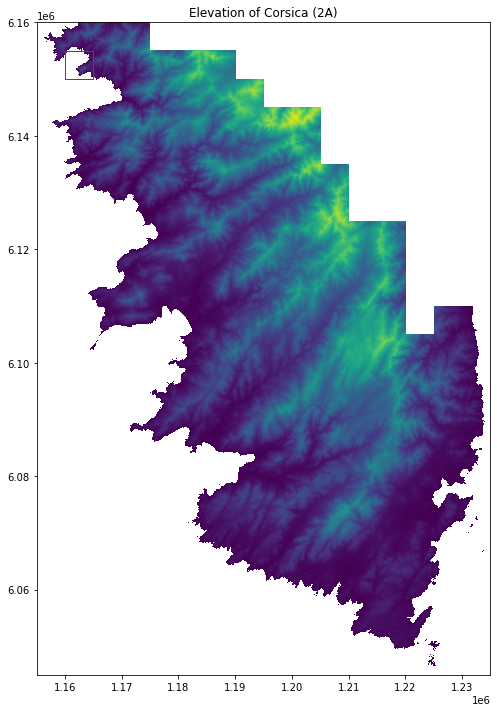

In [102]:
fig, ax = plt.subplots(1, figsize=(12, 12))

# Indicate the location of the sample tiff with a red rectangle.
x1, y1 = file.xllc, file.yllc
dx, dy = file.ncols*file.res, file.nrows*file.res
ax.add_patch(Rectangle((x1, y1), dx, dy, edgecolor = 'red', fill = False))

# PLot the mosaic of the 2A departement.
with rasterio.open(mosaic_path) as img:
    show(img, interpolation='none', ax=ax)

plt.title('Elevation of Corsica (2A)')
plt.show()

#### Group mosaics and upload in Earth Engine as new assets

This procedure has been applied for all departements of France (Continental). Then, the resulting geoTIFF have been upload into Google Earth Engine as new assets.

The final result has been published on [Awsome Google Earth Engine Community Datasets](https://samapriya.github.io/awesome-gee-community-datasets/projects/france5m/).

The Earth Engine snippet reads as follows:

```
var rge_alti5 = ee.Image("projects/sat-io/open-datasets/IGN_RGE_Alti_5m");
```

Sample Code: https://code.earthengine.google.com/b9054b6d5c4d7de1a4af39ff307e73d7

![AGCD](https://user-images.githubusercontent.com/6677629/170712928-9ad828de-85ef-4369-a877-3b328ba0693a.gif)

#### Aknoledgements

Thanks to Samapriya Roy for final merging of the dataset into Earth Engine and for publication on the [AGCD](https://samapriya.github.io/awesome-gee-community-datasets/projects/france5m/).